# Goal of this Version
- clean up the unnecessary
- table of contents
- new data!

# Table of Contents

* hide_toggle() code

Original Kendall Tau Setup
* some original functions
* import data from "frb.csv"
* derive some properties

Kendall Tau Graph Functions
* presets
* kendall tau functions

LFD Functions
* sigma, phi, rho

Fitting Curves

Full Analysis of Parkes + CHIME

In [1]:
print('lets get this ball rolling')

lets get this ball rolling


## hide_toggle() code

In [2]:
#Note that I don't actually know how this function works,
#but it doesn't really matter because I'm not looking to
#edit this function any time soon. It serves its purpose.

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

# Original Kendall Tau Setup
g_new, L_lim1  
sort_by_first, sort_by_1, kt_newform  
L_lim2, kendall_tau

In [3]:
def g_new(z, k): #The improved g-function, which transforms luminosities
    Z = z+1
    Z_c = 3.5
    return Z**k/(1+Z/Z_c)**k

def L_lim1(F_lim, z_i, d_Li, g=g_new, k=0): #finds the limiting luminosity using flux, luminosity distance, and g
    return (F_lim*1e-19)*4*math.pi*(d_Li*3.08567758e25)**2/g(z_i, k)

hide_toggle()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

def sort_by_first(A, B, reverse=False): #SORT USING Z!
    list1, list2 = zip(*sorted(zip(A, B), reverse=reverse))
    return list(list1), list(list2)

def sort_by_1(*args, reverse=False):
    thing = zip(*sorted(zip(*args), reverse=reverse))
    return [list(thang) for thang in thing]

def kt_newform(L, z, F_lim, d_L, g=g_new, k=0, func=L_lim1):
    
    #if necessary, sort by z while keeping reference to L
    z, L, d_L = sort_by_1(z, L, d_L)
        
    R = []
    E = []
    V = []
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        #not considering data points under the cutoff
        if(L[i] < func(F_lim, z[i], d_L[i], g=g, k=k)):
            continue
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_lim, z[i], d_L[i], g=g, k=k) and z[j] <= z[i]): #associated set requirements
                
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

hide_toggle()

In [5]:
#original setup of Kendall Tau, using a generic F_lim, z --> L converter
#now only used in L-Llim space, since cannot account for d_L

def L_lim2(L_limi):
    return L_limi

def kendall_tau(L, Llim, srted=False, func=L_lim2):
    
    #if necessary, sort by z while keeping reference to L
    
    #these days I almost always assume it isn't sorted
    #bc 1) if I assume it is sorted, trouble may ensue
    #and 2) it doesn't take too long to sort it again
    
    if not srted:
        Llim, L = sort_by_first(Llim, L)
        
    R = [] # rank
    E = [] # expected value
    V = [] # (expected) variance
    
    for i in range(len(L)):
        higher = 0
        lower = 0
        
        #similar issue?
        
        if(L[i] < func(Llim[i])): #don't include sources that are not above flux limit
            continue
        
        for j in range(0, i): #since sorted by Llim now, only j < i has z_j < z_i
            if(L[j] >= func(Llim[i]) and Llim[j] <= Llim[i]): #associated set requirements
                if(L[j] > L[i]):
                    higher += 1
                else:
                    lower += 1
        
        R.append((lower+1)/(higher+lower+1))
        E.append(0.5)
        V.append(1/12)
    
    numer = sum(R) - sum(E)
    denom = (sum(V))**0.5
    return numer/denom

hide_toggle()

### import data from "newfrbs.csv"

In [6]:
import pandas as pd
data = pd.read_csv("./data/updatedfrbs.csv")
data.columns = ['frb', 'telescope', 'snr', 'f_p', 'd_L', 'z', 'DM', 'W', 'fl']
hide_toggle()

### derive some properties

In [7]:
#estimate the peak flux of FRBs from 27:54 (27-53)
data['f_p'][27:54] = data['fl'][27:54]/data['W'][27:54]

#create L_p
data['L_p'] = (data['f_p']*1e-19)*4*math.pi*(data['d_L']*3.08567758e25)**2

#create L_lim
#0:32 ASKAP, 32:62: CHIME, 62:90: Parkes
f_lim = [14.8, 0.30, 0.30]
slices = [slice(0,32), slice(32,62), slice(62,90)]
a_Llim, c_Llim, p_Llim = [data['L_p'][slices[i]]*f_lim[i]/data['f_p'][slices[i]] for i in range(3)]
data['L_lim'] = pd.concat([a_Llim, c_Llim, p_Llim], ignore_index=True)
hide_toggle()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
data[0:30]

,frb,telescope,snr,f_p,d_L,z,DM,W,fl,L_p,L_lim
0,FRB170107,ASKAP,16.0,24.100000,2.72,0.48,609.50,2.40,58.0,2.133368e+35,1.310118e+35
1,FRB170416,ASKAP,13.0,19.400000,2.21,0.40,523.20,5.00,97.0,1.133698e+35,8.648827e+34
2,FRB170428,ASKAP,10.5,7.700000,5.03,0.79,991.70,4.40,34.0,2.330975e+35,4.480316e+35
3,FRB170707,ASKAP,9.5,14.800000,0.80,0.17,235.20,3.50,52.0,1.133320e+34,1.133320e+34
4,FRB170712,ASKAP,12.7,37.800000,1.15,0.23,312.79,1.40,53.0,5.981339e+34,2.341900e+34
5,FRB170906,ASKAP,17.0,29.600000,1.52,0.29,390.30,2.50,74.0,8.182572e+34,4.091286e+34
6,FRB171003,ASKAP,13.8,40.500000,1.89,0.35,463.20,2.00,81.0,1.730970e+35,6.325521e+34
7,FRB171004,ASKAP,10.9,22.000000,1.11,0.22,304.00,2.00,44.0,3.243244e+34,2.181819e+34
8,FRB171019,ASKAP,23.4,40.500000,1.89,0.35,460.80,5.40,219.0,1.730970e+35,6.325521e+34
9,FRB171020,ASKAP,19.5,117.600000,0.29,0.06,114.10,3.20,200.0,1.183353e+34,1.489254e+33


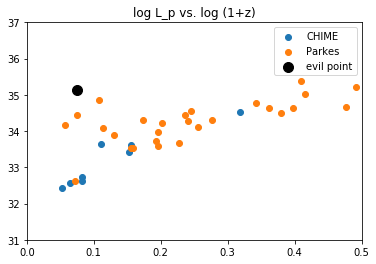

In [32]:
L_p = np.array(data['L_p'])
z = np.array(data['z'])

fig, ax = plt.subplots()
#plt.scatter(np.log10(z[0:27]+1), np.log10(L_p[0:27]), label='ASKAP')
plt.scatter(np.log10(z[54:62]+1), np.log10(L_p[54:62]), label='CHIME')
plt.scatter(np.log10(z[62:90]+1), np.log10(L_p[62:90]), label='Parkes')
#plt.scatter(np.log10(z[27:32]+1), np.log10(L_p[27:32]), label='ASKAP estimated', color='purple')
#plt.scatter(np.log10(z[32:54]+1), np.log10(L_p[32:54]), label='CHIME estimated', color='red')
plt.scatter(np.log10(z[82]+1), np.log10(L_p[82]), label='evil point', color = 'black', s = 100)
plt.ylim([31, 37])
plt.xlim([0, 0.5])
plt.title('log L_p vs. log (1+z)')
plt.legend()
plt.show()
hide_toggle()

In [35]:
#removing the evil point
data = data.drop(82)
data = data.reset_index(drop=True)
hide_toggle()

In [97]:
newdata = data[['f_p', 'fl', 'W']]
newdata['f_p estimate'] = float("NaN")
newdata['f_p estimate'][ASKAP_0[0]] = newdata['fl'][ASKAP_0[0]]/newdata['W'][ASKAP_0[0]]
#newdata['f_p estimate'][CHIME_0[0]] = newdata['fl'][CHIME_0[0]]/newdata['W'][CHIME_0[0]]
#newdata['f_p estimate'][PARKES_0[0]] = newdata['fl'][PARKES_0[0]]/newdata['W'][PARKES_0[0]]
newdata['% change'] = (newdata['f_p estimate']-newdata['f_p'])*100/newdata['f_p']


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [98]:
newdata.iloc[54:62]

,f_p,fl,W,f_p estimate,% change
54,0.6,2.7,1.91,NaN,NaN
55,1.7,5.9,1.44,NaN,NaN
56,0.4,1.4,0.91,NaN,NaN
57,0.4,3.0,4.10,NaN,NaN
58,0.5,3.1,4.50,NaN,NaN
59,0.5,4.4,3.30,NaN,NaN
60,0.6,1.7,1.20,NaN,NaN
61,0.3,1.7,3.00,NaN,NaN


In [99]:
newdata.iloc[54:62]

,f_p,fl,W,f_p estimate,% change
54,0.6,2.7,1.91,NaN,NaN
55,1.7,5.9,1.44,NaN,NaN
56,0.4,1.4,0.91,NaN,NaN
57,0.4,3.0,4.10,NaN,NaN
58,0.5,3.1,4.50,NaN,NaN
59,0.5,4.4,3.30,NaN,NaN
60,0.6,1.7,1.20,NaN,NaN
61,0.3,1.7,3.00,NaN,NaN


0.10010010010009246
-1.5097862254878314
25 27
2


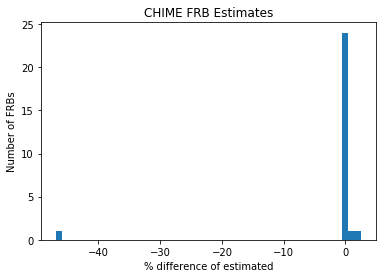

In [100]:
import statistics
dF = list(newdata['% change'])
dF = [x for x in dF if x == x]
plt.hist(dF, 50)
plt.ylabel('Number of FRBs')
plt.xlabel('% difference of estimated')
plt.title('CHIME FRB Estimates')
#plt.xlim(-100,100)
print(statistics.median(dF))
print(sum(dF)/len(dF))
print(len([x for x in dF if ((x <= 0.5 and x >= -0.5))]), len(dF))
print(len([x for x in dF if (x < 0)]))

# Kendall Tau Graph Functions
presets: new ones!!!  
new_L, tau_k, tkgraph  
tkplot  
tau_k2, tk_graph2  
tk_pandas, tk2_pandas

In [11]:
#Presets for the TELESCOPE option

#subscript e stands for estimated
    #orig            : 0:27 ASKAP, 54:62 CHIME, 62:90 Parkes
    #orig + estimated: 0:32 ASKAP, 32:62 CHIME, 62:90 Parkes
ASKAP_0 = (slice(0,27), 'ASKAP', 14.8, '#1f77b4')
ASKAP = (slice(0,32), 'ASKAP', 14.8, '#1f77b4')
CHIME_0 = (slice(54,62), 'CHIME', 0.30, '#2ca02c')
CHIME = (slice(32,62), 'CHIME', 0.30, '#2ca02c')
PARKES_0 = (slice(62,89), 'Parkes', 0.30, '#ff7f0e')
PARKES = (slice(62,89), 'Parkes', 0.30, '#ff7f0e')
ALL = (slice(0,89), 'All FRBs', 0.30, '#1f77b4')
PAC_0 = (slice(54,89), 'Parkes + CHIME (orig)', 0.30, '#1f77b4') # PARKES + CHIME
PAC = (slice(32,89), 'Parkes + CHIME', 0.30, '#1f77b4')
hide_toggle()

In [12]:
def new_L(L, z, k=0, g=g_new):
    return [L[i]/g(z[i], k) for i in range(len(L))]

def tau_k(L_p, z, k, F_lim, d_L, func=L_lim1, g=g_new):
    L_new = new_L(L_p, z, k=k, g=g)
    return kt_newform(L_new, z, F_lim, d_L, g=g, k=k, func=func)

def tkgraph(L_p, z, d_L, func=L_lim1, g=g_new, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL):
    #the current k value
    k = k_min
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    #list of k, tau
    list_k = []
    list_t = []

    k1 = k_min #k closest to tau = 1
    kn1 = k_min #k closest to tau = -1
    k0 = k_min #k closest to t=0

    dif1 = 1e300 #smallest distance so far to tau = 1
    difn1 = 1e300 #smallest distance so far to tau = -1
    dif0 = 1e300

    while(k <= k_max):
        list_k.append(k)
        t_k = tau_k(L_p[tel], z[tel], k, F_LIM, d_L[tel], func=func, g=g)
        list_t.append(t_k)

        if(abs(t_k-1) < dif1):
            dif1 = abs(t_k-1)
            k1 = k
        if(abs(t_k+1) < difn1):
            difn1 = abs(t_k+1)
            kn1 = k
        if(abs(t_k) < dif0):
            dif0 = abs(t_k)
            k0 = k

        k += dk
    
    return list_k, list_t, round(k1,2), round(kn1,2), round(k0,2)

hide_toggle()

In [13]:
def tkplot(list_k, list_t, k1, kn1, k0, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL, PLOT_LINES=True, NAT=False):
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    k1, kn1, k0 = round(k1, 2), round(kn1, 2), round(k0, 2)

    YMAX, YMIN = max(list_t), min(list_t)
    XMAX, XMIN = k_max, k_min
    MAR = 0 #margin
    XMAR = MAR/10 * (abs(XMAX)+abs(XMIN)) #scaling the xmargin
    YMAR = MAR/10 * (abs(YMAX)+abs(YMIN)) #scaling the ymargin

    fig, ax = plt.subplots()  # Create a figure and an axes.
    ax.plot(list_k, list_t, label='τ(k)')
    ax.plot(list_k, [0 for i in range(len(list_k))], label='τ=0')

    if PLOT_LINES:
        ax.plot([k1 for i in range(11)], [YMIN+(1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k = ' + str(kn1))
        ax.plot([kn1 for i in range(11)], [YMIN+(-1-YMIN)*i/10 for i in range(11)], color='black', linestyle='--', label='k = ' + str(k1))
        ax.plot([XMIN + (k1-XMIN)*i/10 for i in range(11)],[1 for i in range(11)], color='black', linestyle='--')
        ax.plot([XMIN + (kn1-XMIN)*i/10 for i in range(11)],[-1 for i in range(11)], color='black', linestyle='--')
    
    if not NAT:
        ax.set_ylim([YMIN-YMAR, YMAX+YMAR])
        ax.set_xlim([XMIN-XMAR, XMAX+XMAR])
    ax.set_xlabel('k')  # Add an x-label to the axes.
    ax.set_ylabel('τ')  # Add a y-label to the axes.
    ax.plot()

    ax.set_title(f"[{telname}] Relation between τ and k")  # Add a title to the axes.
    ax.legend()  # Add a legend.
    return fig, ax

hide_toggle()

In [14]:
#this uses the other version of kendall tau, to be used for L-Llim space. 
#Haven't been able to get it working though.

def tau_k2(L_p, L_plim, z, k, func=L_lim2, g=g_new):
    L_new = new_L(L_p, z, k=k, g=g)
    L_pnew = new_L(L_plim, z, k=k, g=g)
    return kendall_tau(L_new, L_pnew, func=func)

def tk_graph2(L_p, L_lim, z, func=L_lim2, g=g_new, k_min=0, k_max=10, dk=0.01, TELESCOPE=ALL):
    #the current k value
    k = k_min
    
    #expand telescope
    tel, telname, F_LIM, color = TELESCOPE

    #list of k, tau
    list_k = []
    list_t = []

    k1 = k_min #k closest to tau = 1
    kn1 = k_min #k closest to tau = -1
    k0 = k_min #k closest to t=0

    dif1 = 1e300 #smallest distance so far to tau = 1
    difn1 = 1e300 #smallest distance so far to tau = -1
    dif0 = 1e300

    while(k <= k_max):
        list_k.append(k)
        t_k = tau_k2(L_p[tel], L_lim[tel], z[tel], k, func=func, g=g)
        list_t.append(t_k)

        if(abs(t_k-1) < dif1):
            dif1 = abs(t_k-1)
            k1 = k
        if(abs(t_k+1) < difn1):
            difn1 = abs(t_k+1)
            kn1 = k
        if(abs(t_k) < dif0):
            dif0 = abs(t_k)
            k0 = k

        k += dk
    
    return list_k, list_t, round(k1,2), round(kn1,2), round(k0,2)

hide_toggle()

In [15]:
def tk_pandas(data, k_min=0, k_max=10, TELESCOPE=ALL):
    L_p = data['L_p'].to_numpy()
    z = data['z'].to_numpy()
    d_L = data['d_L'].to_numpy()
    list_k, list_t, k1, kn1, k0 = tkgraph(L_p, z, d_L, func=L_lim1, g=g_new, k_min=k_min, k_max=k_max, TELESCOPE=TELESCOPE)
    fig, ax = tkplot(list_k, list_t, k1, kn1, k0, k_min=k_min, k_max=k_max, TELESCOPE=TELESCOPE)
    return fig, ax, k0

def tk2_pandas(data, k_min=0, k_max=10, TELESCOPE=ALL):
    L_p = data['L_p'].to_numpy()
    L_lim = data['L_lim'].to_numpy()
    z = data['z'].to_numpy()
    list_k, list_t, k1, kn1, k0 = tk_graph2(L_p, L_lim, z, k_min=k_min, k_max=k_max, TELESCOPE=TELESCOPE)
    fig, ax = tkplot(list_k, list_t, k1, kn1, k0, k_min=k_min, k_max=k_max, TELESCOPE=TELESCOPE)
    return fig, ax, k0

hide_toggle()

# LFD Functions
sigma_z  
manual_dL, manual_Llim, manual_dVdz  
get_max_z, create_Lcutoffs, phi_L  
devSig, devPhi  
manual_dL, manual_Llim, manual_dVdz  
rho_z

In [16]:
def sigma_z(L, z, d_L, k=0, func=L_lim1, g=g_new, TELESCOPE=ALL): #z0 being the z of interest
    
    tel, telname, F_LIM, color = TELESCOPE
    
    L = new_L(L, z, k=k)
    z, L, d_L = sort_by_1(z[tel], L[tel], d_L[tel])
    
    zs_actual = []
    m = []
    for i in range(len(L)):
        num = 0
        
        if(L[i] < func(F_LIM, z[i], d_L[i], g=g, k=k)): #skip all those under limit
            print(z[i])
            continue
        
        #if above limit, add to list of indices
        zs_actual.append(z[i])
        
        for j in range(0, i): #since sorted by now, only j < i has z_j < z_i
            if(L[j] >= func(F_LIM, z[i], d_L[i], g=g) and z[j] <= z[i]): #associated set requirements
                num += 1
        
        m.append(num+1) #includes itself?
    
    sigma = []
    prod = 1
    for j in range(len(m)):
        prod *= (1 + 1/m[j])
        sigma.append(prod)
    
    return sigma, zs_actual

hide_toggle()

In [17]:
def manual_dL(z, O_M=0.286, O_V=0.714, H_0=69.6, dz = 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev: #already integrated up to a certain point
        z_cur, d_L = prev #assume format is [z, d_L]
        integral = d_L/(d_H*(1+z_cur))
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    return integral*(1+z)*d_H

def manual_Llim(F_lim, z_i, g=g_new, k=0, prev=None):
    if not prev:
        return (F_lim*1e-19)*4*math.pi*(manual_dL(z_i, prev=prev))**2/g(z_i, k)
    d_L = manual_dL(z_i, prev=prev)
    return [(F_lim*1e-19)*4*math.pi*(d_L)**2/g(z_i, k), d_L]

def manual_dVdz(z, O_M=0.286, O_V=0.714, H_0=69.6, dz= 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev:
        z_cur, integral = prev
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    if not prev:
        return 4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5
    return [4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5, integral]

hide_toggle()

In [18]:
def get_max_z(zrange, L_cutoffs, L):
    idx = np.argwhere(np.diff(np.sign(np.array(L_cutoffs) - L))).flatten()
    if(len(idx) < 1):
        return 1e300
    return np.array(zrange)[idx][0]

def create_Lcutoffs(TELESCOPE=ALL):
    tel, telname, F_LIM, color = TELESCOPE
    
    #creation of the cutoff luminosities
    zrange = np.linspace(0, 2.25, num=2000)
    L_cutoffs = []
    
    prev = (0, 0)

    for i in range(len(zrange)):
        L_lim, d_L = manual_Llim(F_LIM, zrange[i], g=g_new, k=0, prev=prev)
        L_cutoffs.append(L_lim)
        prev = (zrange[i], d_L)
        
    zrange, L_cutoffs = sort_by_first(zrange, L_cutoffs)
    return zrange, L_cutoffs

def phi_L(L_p, z, k=0, L_cutoffs=None, zrange=None, func=L_lim1, g=g_new, TELESCOPE=ALL): #z0 being the z of interest
    
    tel, telname, F_LIM, color = TELESCOPE
    
    #creating the L_cutoffs and zrange if None
    if (not L_cutoffs) or (not zrange):
        zrange, L_cutoffs = create_Lcutoffs(TELESCOPE=TELESCOPE)
    cutoffs_prime = new_L(L_cutoffs, zrange, k=k, g=g_new)
    #####################################
    
    ax.plot(zrange, cutoffs_prime, color='black')
    
    #creation of L_prime
    Lprime = new_L(L_p[tel], z[tel], k=k, g=g_new)
    ####################
    
    Lprime, z = sort_by_first(Lprime, z[tel], reverse=True)
    L_actuals = [] # only return the luminosities that are above the limit
    n = []
    for i in range(len(z)):
        num = 0
        z_max = get_max_z(zrange, cutoffs_prime, Lprime[i])
        
        if (z[i] > z_max and z[i] != 0.57 and z[i] != 1.5): #skip things under limit
            ax.scatter(z[i], Lprime[i])
            ax.scatter(z_max, Lprime[i], color='peachpuff')
            print(z[i])
            continue
            
        L_actuals.append(Lprime[i])
        
        for j in range(0, i): #since sorted by largest L' to smallest
                            #should only include L'[j] > L'[i]
                
            if(Lprime[j] >= Lprime[i] and z[j] <= z_max): #associated set requirements
                num += 1
        
        n.append(num+1) #includes itself?
    
    phi = []
    prod = 1
    for l in range(len(n)):
        prod *= (1 + 1/n[l])
        phi.append(prod)
    
    return phi, L_actuals

hide_toggle()

In [19]:
def devSig(z, d1, d2, Z_c, n):
    Z = z+1.0
    fac1 = np.power(Z, d1-1.0)
    fac2 = np.power(np.power(Z/Z_c, n*(d1-d2))+1.0, -1.0/n - 1.0)
    fac3 = d2*np.power(Z/Z_c, n*(d1-d2))+d1
    return fac1*fac2*fac3

def devPhi(L, Phi_0, L_0, d1, d2, n):
    ratio = L/L_0
    fac1 = Phi_0 * np.power(1+ np.power(ratio, n*(d2-d1)), -1.0/n -1.0)
    fac2 = d2*np.power(ratio, n*(d2-d1))+d1
    fac3 = L*np.power(ratio, d1)
    return fac1*fac2/fac3
hide_toggle()

In [20]:
def manual_dL(z, O_M=0.286, O_V=0.714, H_0=69.6, dz = 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev: #already integrated up to a certain point
        z_cur, d_L = prev #assume format is [z, d_L]
        integral = d_L/(d_H*(1+z_cur))
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    return integral*(1+z)*d_H

def manual_Llim(F_lim, z_i, g=g_new, k=0, prev=None):
    if not prev:
        return (F_lim*1e-19)*4*math.pi*(manual_dL(z_i, prev=prev))**2/g(z_i, k)
    d_L = manual_dL(z_i, prev=prev)
    return [(F_lim*1e-19)*4*math.pi*(d_L)**2/g(z_i, k), d_L]

def manual_dVdz(z, O_M=0.286, O_V=0.714, H_0=69.6, dz= 1e-5, prev=None):
    d_H = 299792458/(H_0*3.24077929e-20) #Hubble Distance, in meters!
    
    #numerical integration
    z_cur = 0
    integral = 0
    
    if prev:
        z_cur, integral = prev
    
    while(z_cur < z):
        dI = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        z_cur += dz
        dI2 = dz/(O_M*(1+z_cur)**3 + O_V)**0.5
        integral += (dI+dI2)/2
    
    if not prev:
        return 4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5
    return [4*math.pi*(d_H**3)*integral**2/(O_M*(1+z_cur)**3 + O_V)**0.5, integral]

hide_toggle()

In [21]:
def rho_z(sigma, z_, argsSig):
    dSdz = devSig(z_, *argsSig)
    
    z_cur = 0
    i = 0
    dz = 1e-5
    
    prev = (0, 0)
    
    dVdz = []
    
    while(i < len(z_)):
        dVdzi, integral = manual_dVdz(z_[i], prev=prev)
        prev = (z_[i], integral)
        dVdz.append(dVdzi)
        i += 1
    
    return [(1+z_[i])*dSdz[i]/dVdz[i] for i in range(len(z_))]
hide_toggle()

# Fitting Curves
rawLF, rawPhi, func_phi, func_sigma  
logsigma, logphi

In [22]:
def rawLF(L_p, z, d_L):
    z_, L_p_, d_L_ = sort_by_1(z, L_p, d_L)
    N = [i for i in range(1, len(z_)+1)] # 1 to N inclusive
    return z_, N

def rawPhi(L_p, z, d_L):
    L_p_, z_, d_L_ = sort_by_1(L_p, z, d_L, reverse=True)
    N = [i for i in range(1, len(L_p_)+1)]
    return L_p_, N

def func_phi(L, Phi_0, L_0, d1, d2, n):
    ratio = np.divide(L, L_0)
    return Phi_0*np.divide(np.power(ratio, -d1), np.power(1.0+np.power(ratio, n*(d2-d1)), 1.0/n))

def func_sigma(Z, d1, d2, Z_c, n):
    ratio = np.divide(Z, Z_c)
    return np.divide(np.power(Z, d1), np.power(1.0 + np.power(ratio, n*(d1-d2)), 1.0/n))
hide_toggle()

In [23]:
def logsigma(logZ, d1, d2, Z_c, n):
    return np.log10(func_sigma(np.power(10.0, logZ), d1, d2, Z_c, n))

def logphi(logL, logP, logL0, d1, d2, n):
    #original: logP - d1*(logL-logP) - (1/n)*np.log10(1 + np.power(np.power(10, logL-logL0), n*(d2-d1)))
    return logP - d1*(logL-logL0) - (1/n)*np.log10(1 + np.power(np.power(10, logL-logL0), n*(d2-d1)))
hide_toggle()

# Full Analysis of Parkes + CHIME

In [24]:
L_p = np.array(data['L_p'])
z = np.array(data['z'])
d_L = np.array(data['d_L'])
hide_toggle()

In [180]:
TELE=PAC
Tstr='PAC0' if (TELE is PAC_0) else 'PAC'

### kendall tau both methods

-3.52


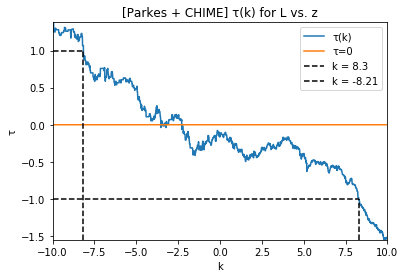

In [181]:
fig, ax, k0 = tk_pandas(data, k_min=-10, k_max=10, TELESCOPE=TELE)
plt.title(f'[{TELE[1]}] τ(k) for L vs. z')
print(k0)
plt.savefig(f'../Plots/tau_{Tstr}.png', dpi=300)
hide_toggle()

-2.48


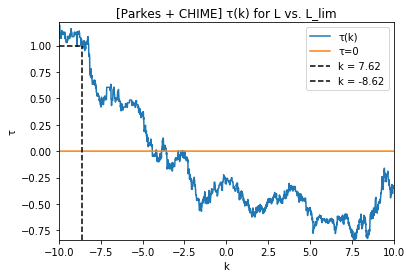

In [183]:
fig, ax, k0 = tk2_pandas(data, k_min=-10, k_max=10, TELESCOPE=TELE)
plt.title(f'[{TELE[1]}] τ(k) for L vs. L_lim')
print(k0)
plt.savefig(f'../Plots/tau2_{Tstr}.png', dpi=300)
hide_toggle()

In [128]:
sigma3, z_3 = sigma_z(L_p, z, d_L, k=-3, TELESCOPE=TELE)
sigma0, z_0 = sigma_z(L_p, z, d_L, k=0, TELESCOPE=TELE)
sigma2, z_2 = sigma_z(L_p, z, d_L, k=2, TELESCOPE=TELE)
sigma4, z_4 = sigma_z(L_p, z, d_L, k=4, TELESCOPE=TELE)

rawL = L_p[TELE[0]]
rawz = z[TELE[0]]
rawdL = d_L[TELE[0]]

arr = [10,22,33] if (TELE is PAC_0) else [14, 16, 18, 20, 32, 44, 55]
rawL = np.delete(rawL, arr)
rawz = np.delete(rawz, arr)
rawdL = np.delete(rawdL, arr)
hide_toggle()

0.69
0.95
2.0
0.69
0.95
2.0
0.69
0.95
2.0
0.69
0.95
2.0


In [129]:
z_, N = rawLF(rawL, rawz, rawdL)

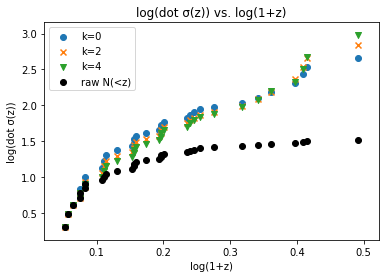

In [131]:
fig, ax = plt.subplots()
if TELE is PAC:
    ax.scatter(np.log10(1+np.array(z_3)), np.log10(sigma3), label='k=-3', marker='2', color = 'magenta')
ax.scatter(np.log10(1+np.array(z_0)), np.log10(sigma0), label='k=0')
ax.scatter(np.log10(1+np.array(z_2)), np.log10(sigma2), label='k=2', marker='x')
ax.scatter(np.log10(1+np.array(z_4)), np.log10(sigma4), label='k=4', marker='v')
#plt.xlim([0, 0.6])
#plt.ylim([0, 2.6])
plt.title(f'log(dot σ(z)) vs. log(1+z)')
plt.xlabel('log(1+z)')
plt.ylabel('log(dot σ(z))')

ax.scatter(np.log10(1+np.array(z_)), np.log10(np.array(N)+1), label='raw N(<z)', color='black')

#plt.ylabel('log N(<z)')
#plt.xlabel('log (1+z)')
#plt.title('log N(<z) vs. log(1+z)')

ax.legend()

#plt.savefig(f'../Plots/dotsigma_{Tstr}.png', dpi=300)
plt.show()
hide_toggle()

In [132]:
zrange, L_cutoffs = create_Lcutoffs(TELESCOPE=TELE)
phi3, Lprime3 = phi_L(L_p, z, k=-3, L_cutoffs=L_cutoffs, zrange=zrange, TELESCOPE=TELE)
phi0, Lprime0 = phi_L(L_p, z, k=0, L_cutoffs=L_cutoffs, zrange=zrange, TELESCOPE=TELE)
phi2, Lprime2 = phi_L(L_p, z, k=2, L_cutoffs=L_cutoffs, zrange=zrange, TELESCOPE=TELE)
phi4, Lprime4 = phi_L(L_p, z, k=4, L_cutoffs=L_cutoffs, zrange=zrange, TELESCOPE=TELE)

2.0
0.95
0.69
2.0
0.95
0.69
2.0
0.95
0.69
2.0
0.95
0.69


In [133]:
L_p_, NPhi = rawPhi(rawL, rawz, rawdL)

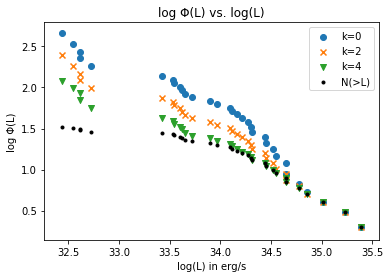

In [135]:
fig, ax = plt.subplots()
if TELE is PAC:
    ax.scatter(np.log10(Lprime0), np.log10(phi3), label='k=-3', marker='2', color='magenta')
ax.scatter(np.log10(Lprime0), np.log10(phi0), label='k=0')
ax.scatter(np.log10(Lprime0), np.log10(phi2), label='k=2', marker='x')
ax.scatter(np.log10(Lprime0), np.log10(phi4), label='k=4', marker='v')
ax.scatter(np.log10(L_p_), np.log10(np.array(NPhi)+1), label='N(>L)', color='black', marker='.')
ax.legend()
#plt.ylim(0, 2.25)
#plt.xlim(32.5, 35.5)
plt.xlabel('log(L) in erg/s')
plt.ylabel('log Φ(L)')
plt.title(f'log Φ(L) vs. log(L)')
#plt.savefig(f'../Plots/phi_{Tstr}.png', dpi=300)
plt.show()
hide_toggle()

In [136]:
import scipy.optimize as opt

#raw numbers
xdata = 1+np.array(z_)
ydata = np.array(N)

#currently k=-3 for PAC and k=4 for PAC_0
xdata2 = 1+np.array(z_4)
ydata2 = sigma4
if TELE is PAC:
    xdata2 = 1+np.array(z_3)
    ydata2 = sigma3

In [169]:
guess = [5.8, 0.45, 1.66, 2.0]
guess2 = [9, 2, 1.58, 1.8]
bounds = [[0, 0, 0, 0], [100, 20, 20, 20]]
print('starting fitting')
#raw numbers
#optrawsig, pcov = opt.curve_fit(func_sigma, (xdata), (ydata+1), guess, bounds=bounds)
optrawsig, pcov = opt.curve_fit(logsigma, np.log10(xdata), np.log10(ydata+1), guess, bounds=bounds)
#optsig, pcov_ = opt.curve_fit(func_sigma, xdata2, ydata2, guess2, bounds=bounds)
optsig, pcov_ = opt.curve_fit(logsigma, np.log10(xdata2), np.log10(ydata2), guess2, bounds=bounds)
print('done')

starting fitting
done


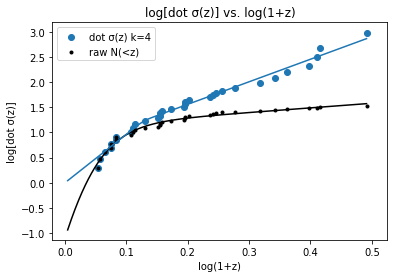

In [177]:
fig, ax = plt.subplots()

ax.scatter(np.log10(xdata2), np.log10(ydata2), label=f'dot σ(z) k={-3 if (TELE is PAC) else 4}')
ax.scatter(np.log10(xdata), np.log10(ydata+1), label='raw N(<z)', color='black', marker='.')

modelzs = np.linspace(0.01, 2.1, 2000)
ax.plot(np.log10(1+modelzs), np.log10(func_sigma(1+modelzs, *optrawsig)), color='black')
ax.plot(np.log10(1+modelzs), np.log10(func_sigma(1+modelzs, *optsig)))
#plt.ylim([0, 2.5])
#plt.xlim([0, 0.5])
plt.xlabel('log(1+z)')
plt.ylabel('log[dot σ(z)]')
plt.title('log[dot σ(z)] vs. log(1+z)')
plt.legend()
plt.savefig(f'../Plots/dotsigmafit_{Tstr}.png', dpi=300)
plt.show()

In [171]:
print(optsig)
print(optrawsig)

[ 9.66321464  4.48281276  1.34283812 19.01545101]
[61.04374964  0.91537387  1.04393612  0.18894622]


In [172]:
argsSig0 = optsig
rho = rho_z(sigma4, np.array(z_4), argsSig0)
if TELE is PAC:
    rho = rho_z(sigma3, np.array(z_3), argsSig0)
rho = np.array(rho)*2.93799894e67
hide_toggle()

In [173]:
argsSigRaw = optrawsig
z_, N = rawLF(rawL, rawz, rawdL)
rawrho = rho_z(np.array(N)+1, np.array(z_), argsSigRaw)
rawrho = np.array(rawrho)*2.93799894e67
hide_toggle()

In [174]:
normrho = np.array(rho)/rho[0]
normrawrho= np.array(rawrho)/rawrho[0]

def SFR(Z):
    return np.power(Z, 2.7)/(1 + np.power(Z/2.9, 5.6))

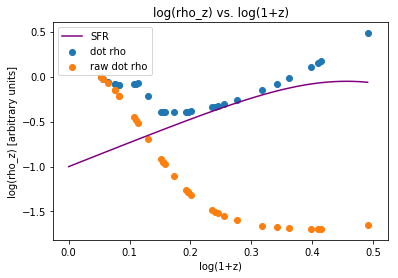

In [179]:
fig, ax = plt.subplots()
ax.scatter(np.log10(1+np.array(z_0)), np.log10(normrho), label='dot rho')
ax.scatter(np.log10(1+np.array(z_)), np.log10(normrawrho), label='raw dot rho')
Z = np.linspace(1, 3.1, 50)
ax.plot(np.log10(Z), np.log10(0.1*SFR(Z)), color='purple', label = 'SFR')
plt.title('log(rho_z) vs. log(1+z)')
plt.ylabel('log(rho_z) [arbitrary units]')
plt.xlabel('log(1+z)')
plt.legend()
plt.savefig(f'../Plots/rhoz_{Tstr}.png', dpi=300)
hide_toggle()